In [1]:
pip install stable_baselines3 shimmy

INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 27.3 MB/s eta 0:00:00


In [2]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv  # Corrected import
from stable_baselines3.common.callbacks import EvalCallback


# Custom Environment for EV Motor Efficiency
class EVMotorEnv(gym.Env):
    def __init__(self):
        super(EVMotorEnv, self).__init__()

        # Define action space: Continuous control (e.g., torque, speed)
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

        # Define observation space: Battery level, speed, torque, etc.
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, -10]),
                                                high=np.array([100, 120, 200, 10]), dtype=np.float32)

        # Initial state
        self.state = np.array([100.0, 60.0, 50.0, 0.0])  # [battery %, speed, torque, gradient]
        self.steps = 0
        self.max_steps = 200

    def reset(self):
        self.state = np.array([100.0, 60.0, 50.0, 0.0])
        self.steps = 0
        return self.state

    def step(self, action):
        self.steps += 1

        # Unpack state variables
        battery, speed, torque, gradient = self.state

        # Unpack actions (torque adjustment, speed adjustment)
        torque_adj, speed_adj = action

        # Simulate environment dynamics
        speed = np.clip(speed + speed_adj * 5, 0, 120)
        torque = np.clip(torque + torque_adj * 10, 0, 200)
        energy_consumption = (speed * torque / 1000) + (gradient * 0.1)
        battery -= energy_consumption * 0.1

        # Reward: Penalize high energy consumption and encourage smooth driving
        reward = -energy_consumption - abs(speed_adj) * 0.5 - abs(torque_adj) * 0.5
        reward += 5 if battery > 20 else -10  # Encourage battery conservation

        # Update state
        self.state = np.array([battery, speed, torque, gradient])

        # Termination conditions
        done = battery <= 0 or self.steps >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode="human"):
        print(f"State: {self.state}")

# Create and wrap the environment
env = DummyVecEnv([lambda: EVMotorEnv()])

# Define and train the PPO model
model = PPO("MlpPolicy", env, verbose=1)
eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

# Train the model
model.learn(total_timesteps=10000, callback=eval_callback)

# Test the trained model
state = env.reset()
for _ in range(200):
    action, _ = model.predict(state)
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
        break


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=336.91 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | 337      |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=336.91 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | 337      |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1500, episode_reward=336.91 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | 337      |
| time/              |          |
|    total_timesteps | 1500     |
---------------------------------
E

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Eval num_timesteps=500, episode_reward=279.51 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | 280      |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=279.51 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | 280      |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1500, episode_reward=279.51 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | 280      |
| time/              |          |
|    total_timesteps | 1500     |
------------------

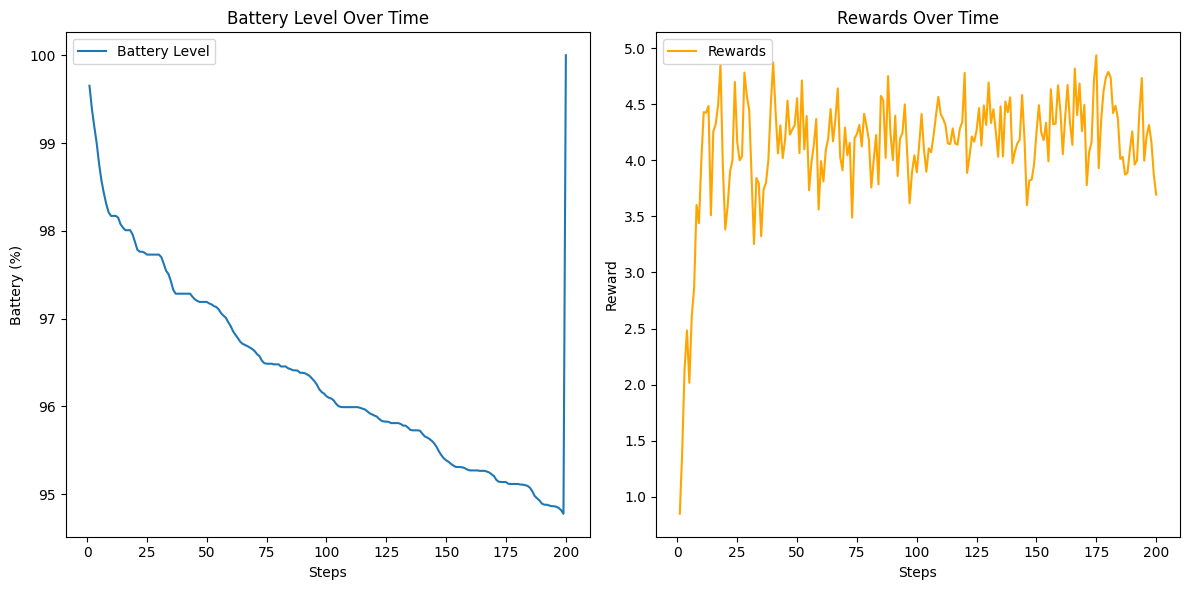

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback

# Custom Environment for EV Motor Efficiency
class EVMotorEnv(gym.Env):
    def __init__(self):
        super(EVMotorEnv, self).__init__()

        # Define action space: Continuous control (e.g., torque, speed)
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

        # Define observation space: Battery level, speed, torque, etc.
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, -10]),
                                                high=np.array([100, 120, 200, 10]), dtype=np.float32)

        # Initial state
        self.state = np.array([100.0, 60.0, 50.0, 0.0])  # [battery %, speed, torque, gradient]
        self.steps = 0
        self.max_steps = 200

    def reset(self):
        self.state = np.array([100.0, 60.0, 50.0, 0.0])
        self.steps = 0
        return self.state

    def step(self, action):
        self.steps += 1

        # Unpack state variables
        battery, speed, torque, gradient = self.state

        # Unpack actions (torque adjustment, speed adjustment)
        torque_adj, speed_adj = action

        # Simulate environment dynamics
        speed = np.clip(speed + speed_adj * 5, 0, 120)
        torque = np.clip(torque + torque_adj * 10, 0, 200)
        energy_consumption = (speed * torque / 1000) + (gradient * 0.1)
        battery -= energy_consumption * 0.1

        # Reward: Penalize high energy consumption and encourage smooth driving
        reward = -energy_consumption - abs(speed_adj) * 0.5 - abs(torque_adj) * 0.5
        reward += 5 if battery > 20 else -10  # Encourage battery conservation

        # Update state
        self.state = np.array([battery, speed, torque, gradient])

        # Termination conditions
        done = battery <= 0 or self.steps >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode="human"):
        print(f"State: {self.state}")

# Create and wrap the environment
env = DummyVecEnv([lambda: EVMotorEnv()])

# Define and train the PPO model
model = PPO("MlpPolicy", env, verbose=1)
eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

# Train the model and log data
training_rewards = []
model.learn(total_timesteps=10000, callback=eval_callback)

# Test the trained model and log results
state = env.reset()
battery_levels = []
rewards = []
steps = []

for step in range(200):
    action, _ = model.predict(state)
    state, reward, done, _ = env.step(action)
    rewards.append(reward[0])
    battery_levels.append(state[0][0])
    steps.append(step + 1)
    if done:
        break

# Visualization of Results
plt.figure(figsize=(12, 6))

# Battery Level
plt.subplot(1, 2, 1)
plt.plot(steps, battery_levels, label="Battery Level")
plt.xlabel("Steps")
plt.ylabel("Battery (%)")
plt.title("Battery Level Over Time")
plt.legend()

# Rewards
plt.subplot(1, 2, 2)
plt.plot(steps, rewards, label="Rewards", color='orange')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1315 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 876       |
|    iterations           | 2         |
|    time_elapsed         | 4         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0092497 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.83     |
|    explained_variance   | -0.00763  |
|    learning_rate        | 0.0003    |
|    loss                 | 2.38e+03  |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.0127   |
|    std                  | 0.988     |
|    value_loss           | 4.75e+03  |
---------------------------------------
-------------

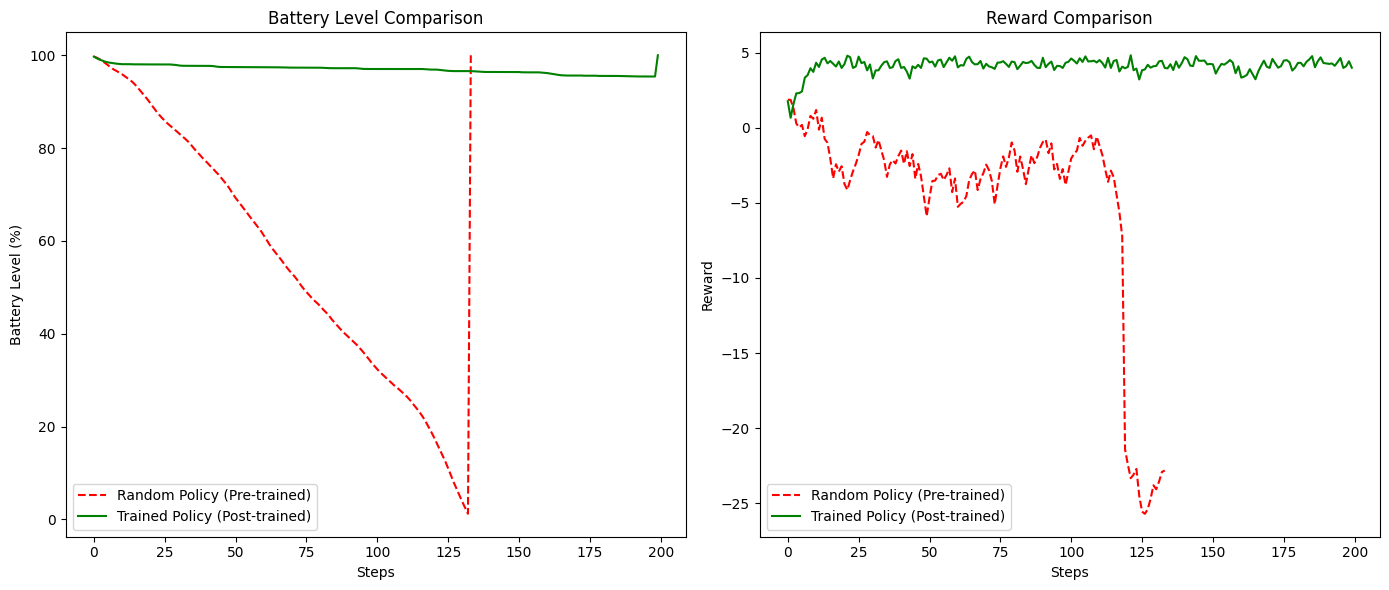

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback

# Custom Environment for EV Motor Efficiency
class EVMotorEnv(gym.Env):
    def __init__(self):
        super(EVMotorEnv, self).__init__()

        # Define action space: Continuous control (e.g., torque, speed)
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

        # Define observation space: Battery level, speed, torque, etc.
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, -10]),
                                                high=np.array([100, 120, 200, 10]), dtype=np.float32)

        # Initial state
        self.state = np.array([100.0, 60.0, 50.0, 0.0])  # [battery %, speed, torque, gradient]
        self.steps = 0
        self.max_steps = 200

    def reset(self):
        self.state = np.array([100.0, 60.0, 50.0, 0.0])
        self.steps = 0
        return self.state

    def step(self, action):
        self.steps += 1

        # Unpack state variables
        battery, speed, torque, gradient = self.state

        # Ensure action is a tuple (torque_adj, speed_adj)
        if isinstance(action, np.ndarray):
            torque_adj, speed_adj = action
        else:
            torque_adj, speed_adj = [action, action]  # If action is scalar, treat as same for both

        # Simulate environment dynamics
        speed = np.clip(speed + speed_adj * 5, 0, 120)
        torque = np.clip(torque + torque_adj * 10, 0, 200)
        energy_consumption = (speed * torque / 1000) + (gradient * 0.1)
        battery -= energy_consumption * 0.1

        # Reward: Penalize high energy consumption and encourage smooth driving
        reward = -energy_consumption - abs(speed_adj) * 0.5 - abs(torque_adj) * 0.5
        reward += 5 if battery > 20 else -10  # Encourage battery conservation

        # Update state
        self.state = np.array([battery, speed, torque, gradient])

        # Termination conditions
        done = battery <= 0 or self.steps >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode="human"):
        print(f"State: {self.state}")

# Create and wrap the environment
env = DummyVecEnv([lambda: EVMotorEnv()])

# Define the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Function to evaluate a policy
def evaluate_policy(policy_model, env, steps=200):
    state = env.reset()
    battery_levels = []
    rewards = []

    for _ in range(steps):
        if policy_model is None:  # Random actions
            action = env.action_space.sample()  # This is already the correct format
        else:  # Trained actions
            action, _ = policy_model.predict(state)

        # Ensure action is in correct format (array with two values)
        if isinstance(action, np.ndarray) and action.ndim == 1:
            action = np.clip(action, -1, 1)  # Ensure values are within action space bounds
        state, reward, done, _ = env.step(action)
        rewards.append(reward[0])
        battery_levels.append(state[0][0])
        if done:
            break
    return battery_levels, rewards

# Pre-trained (Random Policy) Evaluation
random_battery, random_rewards = evaluate_policy(None, env)

# Train the PPO model
model.learn(total_timesteps=10000)

# Post-trained (Trained Policy) Evaluation
trained_battery, trained_rewards = evaluate_policy(model, env)

# Visualization of Results
plt.figure(figsize=(14, 6))

# Battery Level Comparison
plt.subplot(1, 2, 1)
plt.plot(random_battery, label="Random Policy (Pre-trained)", color="red", linestyle="--")
plt.plot(trained_battery, label="Trained Policy (Post-trained)", color="green")
plt.xlabel("Steps")
plt.ylabel("Battery Level (%)")
plt.title("Battery Level Comparison")
plt.legend()

# Rewards Comparison
plt.subplot(1, 2, 2)
plt.plot(random_rewards, label="Random Policy (Pre-trained)", color="red", linestyle="--")
plt.plot(trained_rewards, label="Trained Policy (Post-trained)", color="green")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1315 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 749         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011357117 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.0012      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.05e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.017      |
|    std                  | 0.993       |
|    value_loss           | 4.96e+03    |
-----------------

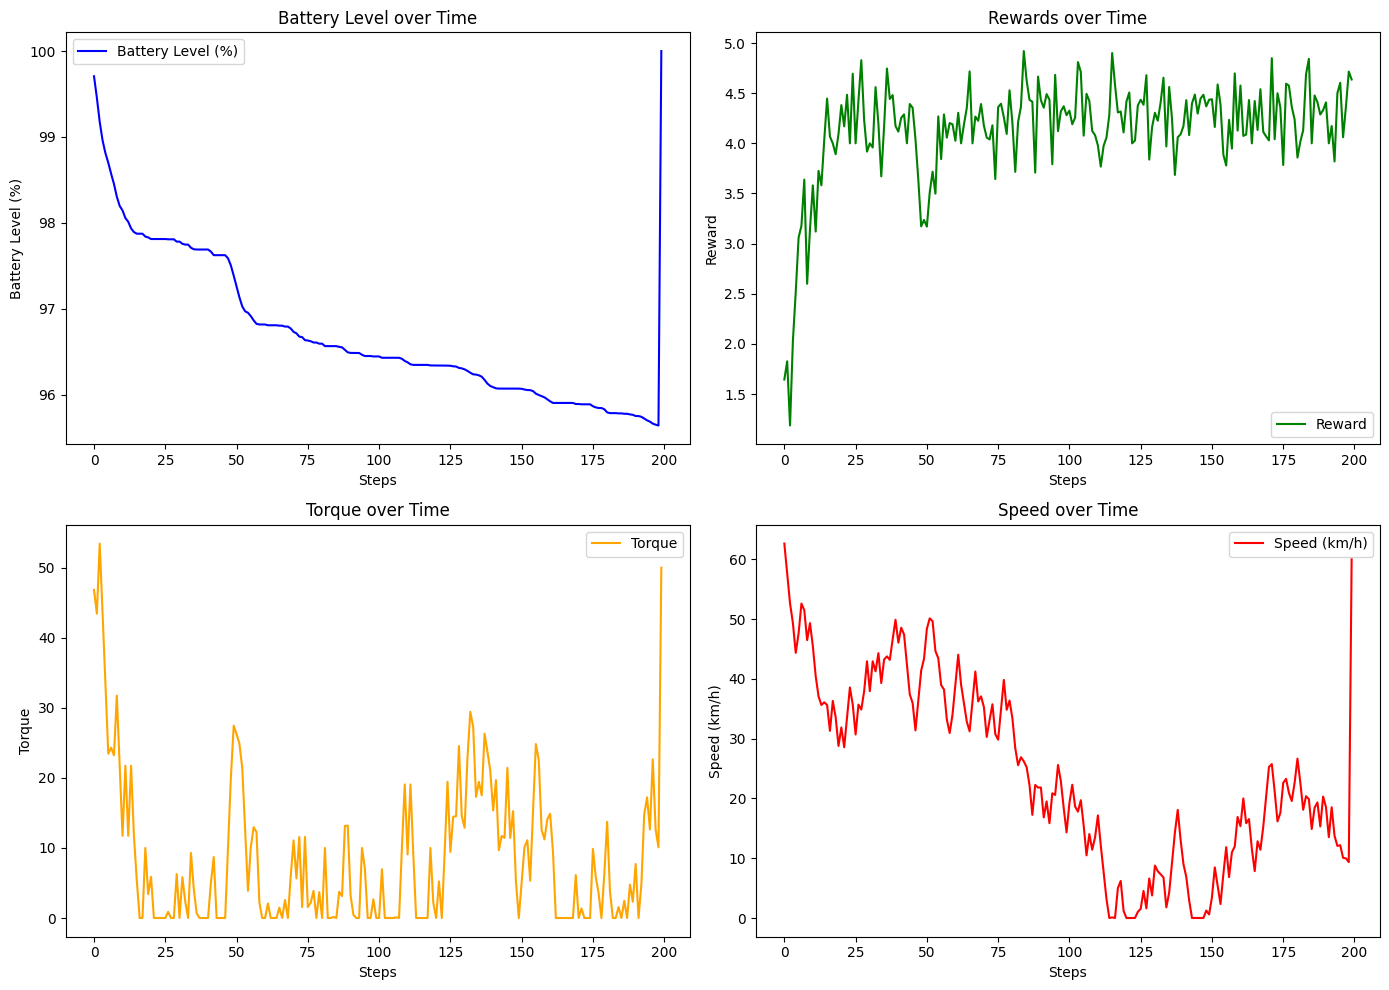

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback

# Custom Environment for EV Motor Efficiency
class EVMotorEnv(gym.Env):
    def __init__(self):
        super(EVMotorEnv, self).__init__()

        # Define action space: Continuous control (e.g., torque, speed)
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

        # Define observation space: Battery level, speed, torque, etc.
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, -10]),
                                                high=np.array([100, 120, 200, 10]), dtype=np.float32)

        # Initial state
        self.state = np.array([100.0, 60.0, 50.0, 0.0])  # [battery %, speed, torque, gradient]
        self.steps = 0
        self.max_steps = 200

    def reset(self):
        self.state = np.array([100.0, 60.0, 50.0, 0.0])
        self.steps = 0
        return self.state

    def step(self, action):
        self.steps += 1

        # Unpack state variables
        battery, speed, torque, gradient = self.state

        # Ensure action is a tuple (torque_adj, speed_adj)
        if isinstance(action, np.ndarray):
            torque_adj, speed_adj = action
        else:
            torque_adj, speed_adj = [action, action]  # If action is scalar, treat as same for both

        # Simulate environment dynamics
        speed = np.clip(speed + speed_adj * 5, 0, 120)
        torque = np.clip(torque + torque_adj * 10, 0, 200)
        energy_consumption = (speed * torque / 1000) + (gradient * 0.1)
        battery -= energy_consumption * 0.1  # Reduced battery based on consumption

        # Reward: Penalize high energy consumption and encourage smooth driving
        reward = -energy_consumption - abs(speed_adj) * 0.5 - abs(torque_adj) * 0.5
        reward += 5 if battery > 20 else -10  # Encourage battery conservation

        # Update state
        self.state = np.array([battery, speed, torque, gradient])

        # Termination conditions
        done = battery <= 0 or self.steps >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode="human"):
        print(f"State: {self.state}")

# Create and wrap the environment
env = DummyVecEnv([lambda: EVMotorEnv()])

# Define the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Function to simulate using the trained model
def simulate_using_trained_policy(policy_model, env, steps=200):
    state = env.reset()
    battery_levels = []
    rewards = []
    torque_values = []
    speed_values = []

    for _ in range(steps):
        # Get the action from the model
        action, _ = policy_model.predict(state)

        # Ensure action is in correct format (array with two values)
        if isinstance(action, np.ndarray) and action.ndim == 1:
            action = np.clip(action, -1, 1)  # Ensure values are within action space bounds

        state, reward, done, _ = env.step(action)

        # Collect data for plotting
        battery_levels.append(state[0][0])  # Battery level
        rewards.append(reward[0])           # Reward
        torque_values.append(state[0][2])   # Torque
        speed_values.append(state[0][1])    # Speed

        if done:
            break

    return battery_levels, rewards, torque_values, speed_values

# Train the PPO model
model.learn(total_timesteps=10000)

# Simulate using the trained PPO policy
battery_levels, rewards, torque_values, speed_values = simulate_using_trained_policy(model, env)

# Visualization of Results
plt.figure(figsize=(14, 10))

# Battery Level
plt.subplot(2, 2, 1)
plt.plot(battery_levels, label="Battery Level (%)", color="blue")
plt.xlabel("Steps")
plt.ylabel("Battery Level (%)")
plt.title("Battery Level over Time")
plt.legend()

# Rewards
plt.subplot(2, 2, 2)
plt.plot(rewards, label="Reward", color="green")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Rewards over Time")
plt.legend()

# Torque Values
plt.subplot(2, 2, 3)
plt.plot(torque_values, label="Torque", color="orange")
plt.xlabel("Steps")
plt.ylabel("Torque")
plt.title("Torque over Time")
plt.legend()

# Speed Values
plt.subplot(2, 2, 4)
plt.plot(speed_values, label="Speed (km/h)", color="red")
plt.xlabel("Steps")
plt.ylabel("Speed (km/h)")
plt.title("Speed over Time")
plt.legend()

plt.tight_layout()
plt.show()
